In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf

/home/kjliu/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def show(img, title=None):
    plt.figure(figsize=(8, 8))
    plt.grid(False)
    plt.axis('off')
    if len(img.shape) > 3:
        img = img.squeeze(0)
    title = title if title else img.shape
    plt.title(title)
    plt.imshow(img)
    
def load_image(path_to_img, img_shape=(224, 224)):
    img = Image.open(path_to_img)
    print(img.size)
    max_dim = 224
    shape = np.array(img.size)
    long_dim = max(shape)
    scale = max_dim / float(long_dim)
    new_shape = (shape * scale).astype(np.int32)
    img = np.array(img.resize(new_shape))
    img = np.expand_dims(img, 0)
    return img

(600, 933)
0 255


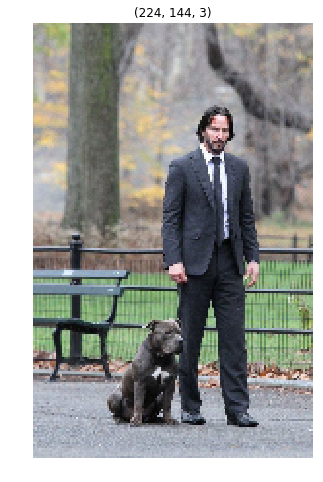

In [3]:
img = load_image("images/john-wick-2-dog.jpg")
print(img.min(), img.max())
show(img)

In [4]:
img

array([[[[180, 173, 163],
         [181, 171, 162],
         [170, 165, 145],
         ...,
         [159, 158, 156],
         [170, 163, 155],
         [178, 171, 161]],

        [[161, 155, 155],
         [162, 154, 151],
         [157, 153, 142],
         ...,
         [190, 174, 161],
         [188, 174, 165],
         [195, 181, 172]],

        [[152, 150, 153],
         [156, 153, 148],
         [150, 150, 140],
         ...,
         [197, 176, 159],
         [188, 172, 159],
         [198, 182, 169]],

        ...,

        [[185, 191, 203],
         [172, 178, 190],
         [182, 188, 200],
         ...,
         [185, 191, 203],
         [188, 192, 204],
         [191, 195, 207]],

        [[177, 183, 195],
         [177, 183, 195],
         [177, 183, 195],
         ...,
         [184, 190, 202],
         [184, 186, 199],
         [181, 183, 196]],

        [[185, 195, 205],
         [186, 196, 206],
         [177, 185, 196],
         ...,
         [189, 193, 205],
        

In [5]:
img = tf.keras.applications.vgg19.preprocess_input(img.astype(float))
img.shape

(1, 224, 144, 3)

# server mrthod

In [6]:
import requests
import json
import base64
headers = {"content-type": "application/json"}
json_response = requests.get('http://localhost:8501/v1/models/model/metadata', headers=headers)
result = json.loads(json_response.text)
result

{'model_spec': {'name': 'model', 'signature_name': '', 'version': '1'},
 'metadata': {'signature_def': {'signature_def': {'activation': {'inputs': {'input': {'dtype': 'DT_FLOAT',
       'tensor_shape': {'dim': [{'size': '-1', 'name': ''},
         {'size': '224', 'name': ''},
         {'size': '224', 'name': ''},
         {'size': '3', 'name': ''}],
        'unknown_rank': False},
       'name': 'input_1:0'}},
     'outputs': {'block1_conv1': {'dtype': 'DT_INT32',
       'tensor_shape': {'dim': [{'size': '-1', 'name': ''},
         {'size': '224', 'name': ''},
         {'size': '224', 'name': ''},
         {'size': '8', 'name': ''}],
        'unknown_rank': False},
       'name': 'strided_slice:0'},
      'block1_conv2': {'dtype': 'DT_INT32',
       'tensor_shape': {'dim': [{'size': '-1', 'name': ''},
         {'size': '224', 'name': ''},
         {'size': '224', 'name': ''},
         {'size': '8', 'name': ''}],
        'unknown_rank': False},
       'name': 'strided_slice_1:0'}},
    

In [32]:
from io import BytesIO
buff = BytesIO(img.tobytes())
# new_image_string = base64.b64encode(buff.getvalue())
data = json.dumps(
    {
        'signature_name': 'deconv', 
#         'instances':[{'b64':base64.b64encode(buff.getvalue()).decode("utf-8")}]
        'instances':img.tolist()
    }
)
data[:500]

'{"signature_name": "deconv", "instances": [[[[59.06100000000001, 56.221000000000004, 56.31999999999999], [58.06100000000001, 54.221000000000004, 57.31999999999999], [41.06100000000001, 48.221000000000004, 46.31999999999999], [17.061000000000007, 39.221000000000004, 28.319999999999993], [23.061000000000007, 45.221000000000004, 28.319999999999993], [26.061000000000007, 55.221000000000004, 31.319999999999993], [31.061000000000007, 65.221, 42.31999999999999], [30.061000000000007, 64.221, 48.31999999'

In [33]:
import requests
headers = {"content-type": "application/json", "X-Requested-With": "XMLHttpRequest"}
# json_response = requests.post('http://140.114.85.27:8501/v1/models/deconv:predict', data=data, headers=headers)
json_response = requests.post('http://140.114.85.27:5000/model/predict/', data=data, headers=headers)
print(json_response.text[:500])
result = json.loads(json_response.text)

{
  "predictions": [
    [
      [
        [
          [
            0, 
            0, 
            0
          ], 
          [
            0, 
            0, 
            2
          ], 
          [
            0, 
            0, 
            4
          ], 
          [
            0, 
            0, 
            5
          ], 
          [
            0, 
            0, 
            5
          ], 
          [
            0, 
            0, 
            6
          ], 
          [
           


In [10]:
out_img = np.array(result['predictions'][0]).astype(float)
out_img.shape

(224, 144, 4)

In [11]:
# display images in row format
def display_in_row(features, figname='', max_images=8, images_per_row=8):
    n_features = features.shape[0]
    n_features = min(n_features, max_images)

    h_size = features.shape[1]
    w_size = features.shape[2]
    n_cols = (n_features // (images_per_row+1)) + 1
    images_per_row = min(n_features, images_per_row)
    
    if features.ndim == 4:
        display_grid = np.ones((h_size * n_cols, images_per_row * w_size, features.shape[-1]), dtype=np.float32)
    else:
        display_grid = np.ones((h_size * n_cols, images_per_row * w_size), dtype=np.float32)
        
    # plot on grid
    for col in range(n_cols):
        for row in range(images_per_row):
            if col * images_per_row + row < n_features:
                channel_image = features[col * images_per_row + row, ...]
                display_grid[col * h_size : (col + 1) * h_size, row * w_size : (row + 1) * w_size] = channel_image
    scale = 1.5 / w_size
    plt.figure(figsize=(scale * display_grid.shape[1], scale * display_grid.shape[0]))
    plt.axis('off')
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='gray')  
    plt.tight_layout()
    plt.show()
def deprocess(img):
    img = img.copy()
    # normalized tensor: center at 0., std at 0.1
    img -= img.mean()
    img /= (img.std() + 1e-5)
    img *= 0.1
    # clip to [0, 1]
    img += 0.5
    img = np.clip(img, 0, 1)
    
    img *= 255.
    return np.clip(img, 0, 255).astype('uint8')

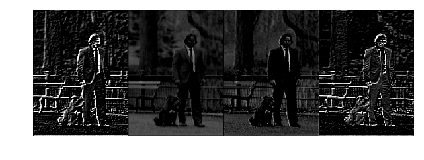

In [12]:
vis_act = [deprocess(out_img[...,:16]).transpose((2, 0, 1))]
for act in vis_act:
    display_in_row(act)

In [13]:
out_img = np.array(result['predictions'][0]['block1_conv2']).astype(float)
out_img.shape

TypeError: list indices must be integers or slices, not str

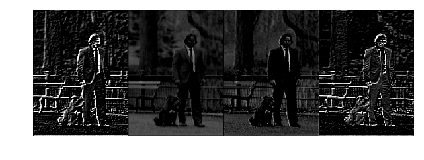

In [14]:
vis_act = [deprocess(out_img[...,:16]).transpose((2, 0, 1))]
for act in vis_act:
    display_in_row(act)